<a href="https://colab.research.google.com/github/Ahmed-Mahmoud-Dev/Sentiment-Analysis-Task/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install opendatasets

# **1. Install and Import Dependencies**

In [39]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **2. Download and Load Dataset**

In [6]:
od.download('https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format')

train_data = pd.read_csv('/content/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv')
valid_data = pd.read_csv('/content/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv')
test_data = pd.read_csv('/content/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmedmahmoudramadan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format


# **3. Exploratory Data Analysis**

In [8]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(40000, 2)
(5000, 2)
(5000, 2)


In [9]:
train_data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [10]:
test_data.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [11]:
valid_data.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


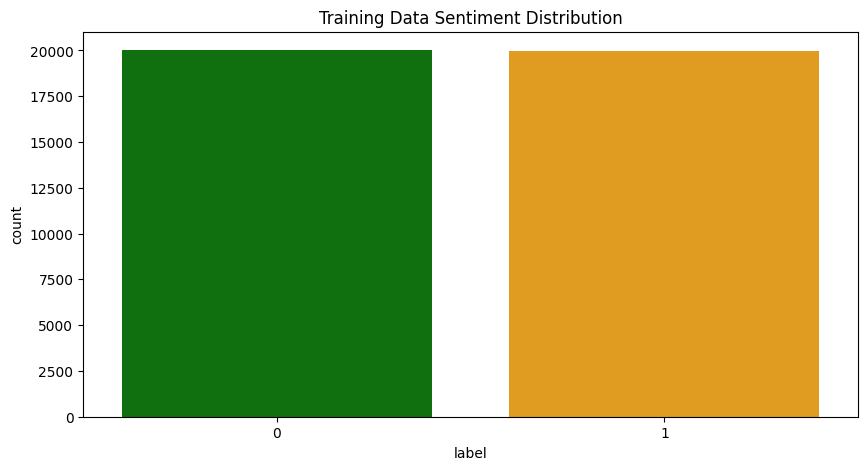

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=train_data, palette=['green', 'orange'])
plt.title('Training Data Sentiment Distribution')
plt.show()

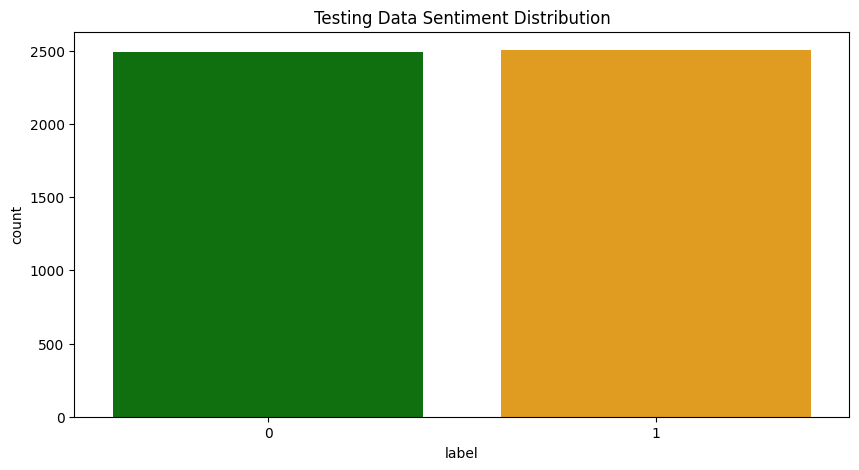

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=test_data, palette=['green', 'orange'])
plt.title('Testing Data Sentiment Distribution')
plt.show()

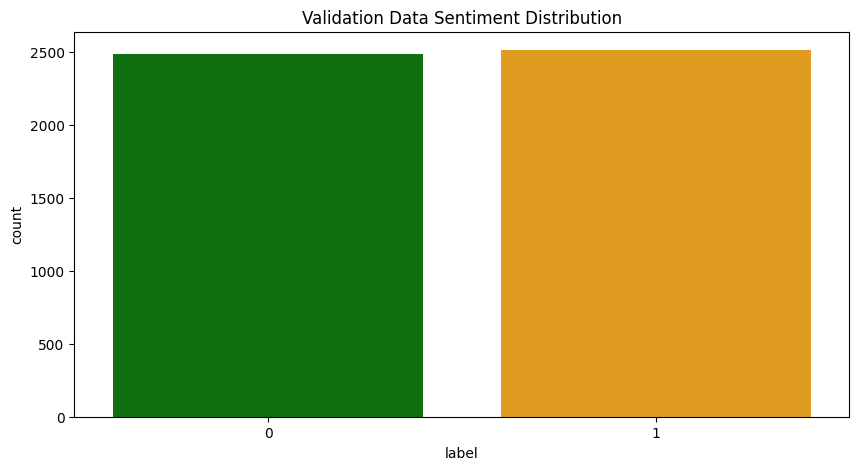

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=valid_data, palette=['green', 'orange'])
plt.title('Validation Data Sentiment Distribution')
plt.show()

In [15]:
train_data['label'].unique(), valid_data['label'].unique(), test_data['label'].unique()

(array([0, 1]), array([0, 1]), array([0, 1]))

In [17]:
train_data.isnull().sum(), valid_data.isnull().sum(), test_data.isnull().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

# **4. Data Preprocessing**

In [18]:
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return " ".join([word.lower() for word in text.split() if word not in STOPWORDS and len(word) > 2])

def preprocess(df):
    df['clean_text'] = df['text'].apply(clean_text)
    return df

train_data = preprocess(train_data)
valid_data = preprocess(valid_data)
test_data = preprocess(test_data)

In [23]:
train_data['text'][10]

"I can't believe people are looking for a plot in this film. This is Laural and Hardy. Lighten up already. These two were a riot. Their comic genius is as funny today as it was 70 years ago. Not a filthy word out of either mouth and they were able to keep audiences in stitches. Their comedy wasn't sophisticated by any stretch. If a whoopee cushion can't make you grin, there's no reason to watch any of the stuff these guys did. It was a simpler time, and people laughed at stuff that was funny without a plot. I guess it takes a simple mind to enjoy this stuff, so I qualify. Two man comedy teams don't compute, We're just too sophisticated... Aren't we fortunate?"

In [24]:
train_data.head()

,text,label,clean_text
0,I grew up (b. 1965) watching and loving the Th...,0,grew watching loving thunderbirds all mates sc...
1,"When I put this movie in my DVD player, and sa...",0,when put movie dvd player sat coke chips expec...
2,Why do people who do not know what a particula...,0,why people know particular time past like feel...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movies bor...
4,Im a die hard Dads Army fan and nothing will e...,1,die hard dads army fan nothing ever change got...


In [25]:
valid_data.head()

,text,label,clean_text
0,It's been about 14 years since Sharon Stone aw...,0,years since sharon stone awarded viewers leg c...
1,someone needed to make a car payment... this i...,0,someone needed make car payment truly awful ma...
2,The Guidelines state that a comment must conta...,0,the guidelines state comment must contain mini...
3,This movie is a muddled mish-mash of clichés f...,0,this movie muddled mish mash clichés recent ci...
4,Before Stan Laurel became the smaller half of ...,0,before stan laurel became smaller half time gr...


In [26]:
test_data.head()

,text,label,clean_text
0,I always wrote this series off as being a comp...,0,always wrote series complete stink fest jim be...
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0,watched dir steve purcell typical mary kate as...
2,This movie was so poorly written and directed ...,0,this movie poorly written directed fell asleep...
3,The most interesting thing about Miryang (Secr...,1,the interesting thing miryang secret sunshine ...
4,"when i first read about ""berlin am meer"" i did...",0,first read berlin meer expect much thought rig...


# **5. Tokenization and Padding**



In [41]:
train_texts = train_data['clean_text'].tolist()
valid_texts = valid_data['clean_text'].tolist()
test_texts = test_data['clean_text'].tolist()

text_tokenizer = Tokenizer(oov_token="<OOV>")
text_tokenizer.fit_on_texts(train_texts)
vocab_size = len(text_tokenizer.word_index) + 1

MAX_LEN = 120

def encode_pad(texts):
    sequences = text_tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

X_train = encode_pad(train_texts)
X_valid = encode_pad(valid_texts)
X_test = encode_pad(test_texts)

y_train = train_data['label'].values
y_valid = valid_data['label'].values
y_test = test_data['label'].values

# **6. Build and Compile the Model**


In [42]:
train_texts = train_data['clean_text'].tolist()
valid_texts = valid_data['clean_text'].tolist()
test_texts = test_data['clean_text'].tolist()

text_tokenizer = Tokenizer(oov_token="<OOV>")
text_tokenizer.fit_on_texts(train_texts)
vocab_size = len(text_tokenizer.word_index) + 1

MAX_LEN = 100

def encode_pad(texts):
    sequences = text_tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

X_train = encode_pad(train_texts)
X_valid = encode_pad(valid_texts)
X_test = encode_pad(test_texts)

y_train = train_data['label'].values
y_valid = valid_data['label'].values
y_test = test_data['label'].values

# **7. Build and Compile the Model**

In [44]:
EMBED_DIM = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
    SimpleRNN(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    GRU(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])

# **8. Train the Model**

In [45]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, mode='min'),
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_accuracy', restore_best_weights=True)
]

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), batch_size=128, verbose=1, callbacks=callbacks)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 365ms/step - accuracy: 0.5546 - loss: 0.6656 - val_accuracy: 0.8654 - val_loss: 0.3212 - learning_rate: 5.0000e-04
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 362ms/step - accuracy: 0.9051 - loss: 0.2524 - val_accuracy: 0.8830 - val_loss: 0.2828 - learning_rate: 5.0000e-04
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 367ms/step - accuracy: 0.9719 - loss: 0.0897 - val_accuracy: 0.8774 - val_loss: 0.4375 - learning_rate: 5.0000e-04
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 366ms/step - accuracy: 0.9931 - loss: 0.0266 - val_accuracy: 0.8662 - val_loss: 0.6263 - learning_rate: 5.0000e-04


# **9. Plot Training Metrics**

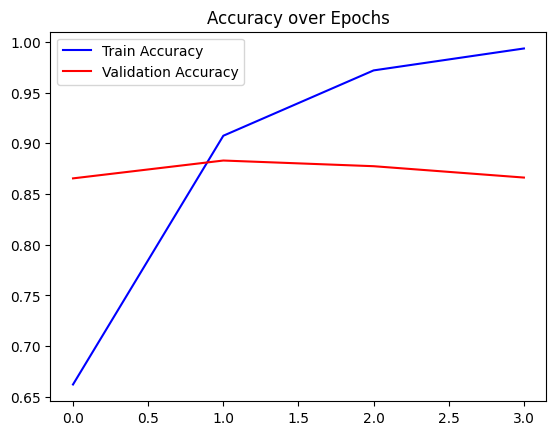

In [46]:
def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

plot_metrics(history)

# **10. Evaluate the Model**


In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8783 - loss: 0.2930
Test Accuracy: 0.8818


# **11. Predict Sentiment on New Text**


In [48]:
def predict_sentiment(text):
    processed_text = preprocess(pd.DataFrame({'text': [text]}))['clean_text'].tolist()
    encoded_text = encode_pad(processed_text)
    prediction = model.predict(encoded_text)
    return 'Positive' if prediction > 0.5 else 'Negative'

print(predict_sentiment("Amazing customer service!"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
Positive
